In [1]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

from IPython.display import display

Using TensorFlow backend.


# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_12
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096

random.seed()

## Load the pre-processed training file. The training file already contains the anchors and cluster information.


In [3]:
INPUT_FILE_PATH = './input/labels_train_full'

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))



### Statistics about the breeds in dataset

In [4]:
display(df_train.groupby(['breed']).agg(['count']))

,id,encoding,anp,cluster
,count,count,count,count
breed,,,,
affenpinscher,64,64,64,64
afghan_hound,92,92,92,92
african_hunting_dog,68,68,68,68
airedale,85,85,85,85
american_staffordshire_terrier,59,59,59,59
appenzeller,62,62,62,62
australian_terrier,81,81,81,81
basenji,88,88,88,88


### Breeds and sample of pictures

'total number of breeds 120'

sussex_spaniel


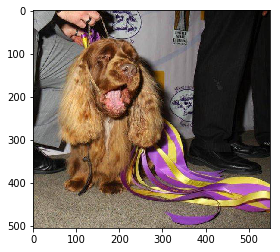

dhole


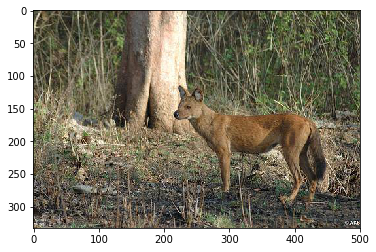

In [5]:
breeds = df_train['breed'].unique()

display('total number of breeds ' + str(len(breeds)))


def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)

    
def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()

    
sample_by_breed(df_train)
sample_by_breed(df_train)

## Load the pre-processed triplets training file
## Shuffle the triplets so that we don't just train all of a single breed first 

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

df_triplets = shuffle_triplets(df_triplets)
print('Total number of triplets ' + str(df_triplets.shape[0]))

Total number of triplets 11605356


### Show samples of the triplets

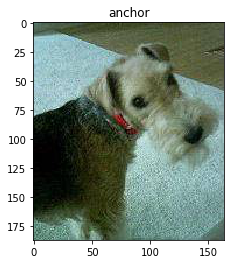

./input/train-2/6b8520585a1539a9192d073ff044cf53.jpg
lakeland_terrier


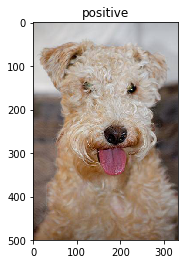

./input/train-2/793c3e6ddbee03b56b350aeb3910682c.jpg
lakeland_terrier


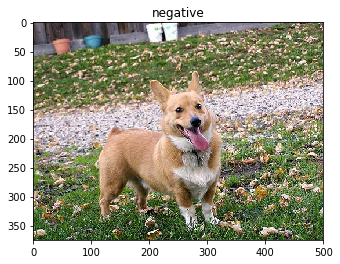

./input/train-2/6f6b3a96442e671c9cb62815a1e87dfa.jpg
pembroke


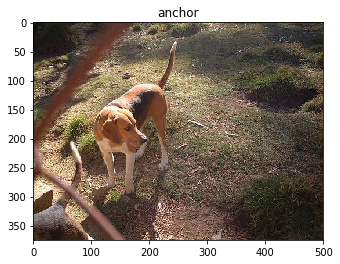

./input/train-2/77bbd2303fa579c249dfc4ce01832aac.jpg
english_foxhound


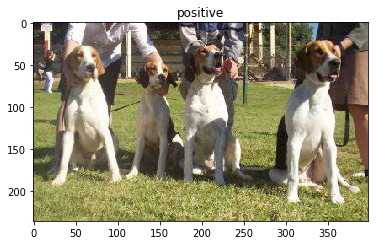

./input/train-2/9862df0bfdc859432fea16cd147ca02e.jpg
english_foxhound


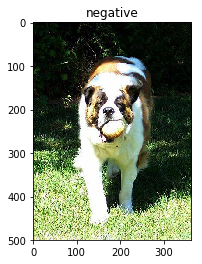

./input/train-2/2f4a4f7881b5bcee285cd7a09fcbf0d7.jpg
saint_bernard


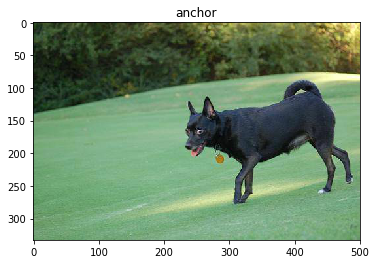

./input/train-2/4d0aaeb97332aebac90f0ca42a9ff1eb.jpg
schipperke


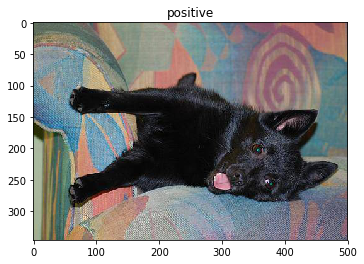

./input/train-2/2bc3544c614107dd07410e98b9b6d7eb.jpg
schipperke


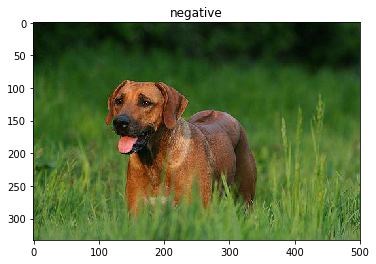

./input/train-2/37f1a6d8a5a2e3929afa8bdfc47aea2c.jpg
rhodesian_ridgeback


In [7]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


In [ ]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001

def load_triplets(df_triplets):
    n_triplets = df_triplets.shape[0]
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    for i, triplet in df_triplets.iterrows():
        anchors[i] = np.loadtxt(triplet['anchor_encoding'])
        pos[i] = np.loadtxt(triplet['positive_encoding'])
        negs[i] = np.loadtxt(triplet['negative_encoding'])
        i = i + 1
        if (i % 1000 == 0):
            print('Loaded ' + str(i) + ' triplets')
    print('Loaded ' + str(n_triplets))
    
    return anchors, pos, negs



### Load the encoding for the given triplets into memory
### Train the model with the whole training set

because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies


In [ ]:
anchors, pos, negs = load_triplets(df_triplets)
n_triplets = df_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))


training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=100, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 6000 triplets
Loaded 7000 triplets
Loaded 8000 triplets
Loaded 9000 triplets
Loaded 10000 triplets
Loaded 11000 triplets
Loaded 12000 triplets
Loaded 13000 triplets
Loaded 14000 triplets
Loaded 15000 triplets
Loaded 16000 triplets
Loaded 17000 triplets
Loaded 18000 triplets
Loaded 19000 triplets
Loaded 20000 triplets
Loaded 21000 triplets
Loaded 22000 triplets
Loaded 23000 triplets
Loaded 24000 triplets
Loaded 25000 triplets
Loaded 26000 triplets
Loaded 27000 triplets
Loaded 28000 triplets
Loaded 29000 triplets
Loaded 30000 triplets
Loaded 31000 triplets
Loaded 32000 triplets
Loaded 33000 triplets
Loaded 34000 triplets
Loaded 35000 triplets
Loaded 36000 triplets
Loaded 37000 triplets
Loaded 38000 triplets
Loaded 39000 triplets
Loaded 40000 triplets
Loaded 41000 triplets
Loaded 42000 triplets
Loaded 43000 triplets
Loaded 44000 triplets
Loaded 45000 triplets
Loaded 46000 triple

Loaded 362000 triplets
Loaded 363000 triplets
Loaded 364000 triplets
Loaded 365000 triplets
Loaded 366000 triplets
Loaded 367000 triplets
Loaded 368000 triplets
Loaded 369000 triplets
Loaded 370000 triplets
Loaded 371000 triplets
Loaded 372000 triplets
Loaded 373000 triplets
Loaded 374000 triplets
Loaded 375000 triplets
Loaded 376000 triplets
Loaded 377000 triplets
Loaded 378000 triplets
Loaded 379000 triplets
Loaded 380000 triplets
Loaded 381000 triplets
Loaded 382000 triplets
Loaded 383000 triplets
Loaded 384000 triplets
Loaded 385000 triplets
Loaded 386000 triplets
Loaded 387000 triplets
Loaded 388000 triplets
Loaded 389000 triplets
Loaded 390000 triplets
Loaded 391000 triplets
Loaded 392000 triplets
Loaded 393000 triplets
Loaded 394000 triplets
Loaded 395000 triplets
Loaded 396000 triplets
Loaded 397000 triplets
Loaded 398000 triplets
Loaded 399000 triplets
Loaded 400000 triplets
Loaded 401000 triplets
Loaded 402000 triplets
Loaded 403000 triplets
Loaded 404000 triplets
Loaded 4050

In [ ]:
def triplet_tuple(id_value, breed_value, encoding_value):
    return [id_value, breed_value, encoding_value]

def create_triplet(anchor_tuple, positive_tuple, negative_tuple):
    result = []
    for value in anchor_tuple:
        result.append(value)
    for value in positive_tuple:
        result.append(value)
    for value in negative_tuple:
        result.append(value)
    return result

def extract_triplets(df_mismatch, df_train):
    new_triplets_list = []

    for i, bad_pred in df_mismatch.iterrows():
        pred_anchors = df_train.loc[(df_train.breed == bad_pred.breed)]
        for i, pred_anchor in pred_anchors.iterrows():
            anchor = triplet_tuple(pred_anchor['id'], pred_anchor['breed'], pred_anchor['encoding'])
            positive = triplet_tuple(bad_pred['id'], bad_pred['breed'], bad_pred['encoding'])
            negative = triplet_tuple(bad_pred['prediction_id'], bad_pred['prediction_breed'], bad_pred['prediction_encoding'])
            new_triplets_list.append(create_triplet(anchor, positive, negative))
#             new_triplets_list.append(create_triplet(positive, anchor, negative))

    df_new_triplets = pd.DataFrame(new_triplets_list, columns=['anchor_id', 'anchor_type', 'anchor_encoding', 'positive_id', 'positive_type', 'positive_encoding', 'negative_id', 'negative_type', 'negative_encoding'])
    return df_new_triplets

### Load the bad prediction and train the model to recognize these against the corresponding anchors

In [ ]:
df_new_triplets = extract_triplets(df_train_results_mismatch, df_train)
print(df_new_triplets.shape)
df_new_triplets.head()

anchors, pos, negs = load_triplets(df_new_triplets)
n_triplets = df_new_triplets.shape[0]
y_dummies = np.zeros((n_triplets, 1, n_triplets))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=50, shuffle=True)

df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))

df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
